# Waymo Open Sim Agents Challenge Tutorial 🚗

Follow along the
[Sim Agents Challenge web page](https://waymo.com/open/challenges/2025/sim-agents)
for more details.

This tutorial demonstrates:

- How to load the motion dataset.
- How to simulate a rollout (as specified by the challenge) from a single scenario and a simple policy.
- How to visualize the results.
- How to evaluate the simulation locally.
- How to package the simulations into the protobuf used for submission.

## Package installation 🛠️

In [1]:
# Imports
import os
import tarfile

# Set matplotlib to jshtml so animations work with colab.
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# Hide GPU from TensorFlow so it doesn't reserve VRAM.
tf.config.set_visible_devices([], 'GPU')
import tqdm
from utils.geometry import wrap_angle

from waymo_open_dataset.protos import scenario_pb2
from waymo_open_dataset.protos import sim_agents_submission_pb2
from waymo_open_dataset.utils import trajectory_utils
from waymo_open_dataset.utils.sim_agents import submission_specs
from waymo_open_dataset.utils.sim_agents import visualizations
from waymo_open_dataset.wdl_limited.sim_agents_metrics import metric_features
from waymo_open_dataset.wdl_limited.sim_agents_metrics import metrics

rc('animation', html='jshtml')

2025-12-18 08:11:26.296741: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 08:11:26.322172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 08:11:27.208577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-12-18 08:11:28.188854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node z

# Loading the data

Visit the [Waymo Open Dataset Website](https://waymo.com/open/) to download the
full dataset.

In [2]:
# Please edit.

# Replace this path with your own tfrecords./
# This tutorial is based on using data in the Scenario proto format directly,
# so choose the correct dataset version.
VAL_DATASET_FOLDER = '/home/hansung/end2end_ad/datasets/waymo_open_dataset_motion_v_1_3_0/uncompressed/scenario/validation/'
TEST_DATASET_FOLDER = '/home/hansung/end2end_ad/datasets/waymo_open_dataset_motion_v_1_3_0/uncompressed/scenario/testing/'
VALIDATION_FILES = os.path.join(VAL_DATASET_FOLDER, 'validation.tfrecord*')
TEST_FILES = os.path.join(TEST_DATASET_FOLDER, 'testing.tfrecord*')



We create a dataset starting from the validation set, which is smaller than the
training set but contains future states (which the test set does not). We need
future information to demonstrate how to evaluate your submission locally.

In [3]:
# Define the dataset from the TFRecords.
dataset_mode = 'val' #[val,test]
if dataset_mode == 'val':
    filenames = tf.io.matching_files(VALIDATION_FILES)
else: 
    filenames = tf.io.matching_files(TEST_FILES)
dataset = tf.data.TFRecordDataset(filenames)
# Since these are raw Scenario protos, we need to parse them in eager mode.
dataset_iterator = dataset.as_numpy_iterator()

In [9]:
bytes_example = next(dataset_iterator)
scenario = scenario_pb2.Scenario.FromString(bytes_example)
id = scenario.scenario_id

print(f'Checking type: {type(scenario)}')
print(f'Loaded scenario with ID: {scenario.scenario_id}')

Checking type: <class 'waymo_open_dataset.protos.scenario_pb2.Scenario'>
Loaded scenario with ID: 8648f5e79d851915


# Simulation stage 🤖

Please read the
[challenge web page](https://waymo.com/open/challenges/2025/sim-agents) first,
where we explain simulation requirements and settings.

Many of the requirements specified on the challenge website are encoded into
`waymo_open_dataset/utils/sim_agents/submission_specs.py`. For example, we have
specifications of: - Simulation length and frequency. - Number of parallel
simulations required. - Agents to simulate and agents to evaluate.

### What to simulate

There are multiple levels of fidelity we could ask to perform these simulations,
but we are going to follow a very similar abstraction used for the Waymo Open
Motion Dataset: we represent objects as boxes, and we are interested just in how
they *move* around the world.

Specifically, contestants will need to simulate the fields specified in the
`sim_agents_submission_pb2.SimulatedTrajectory` proto, namely:
- 3D coordinates of the boxes centers (x/y/z, same reference frame as the original Scenario).
- Heading of those objects (again, same definition as the original Scenario proto).

All the objects that are valid at the last step of the initial state (i.e. the
11th when 1-indexed, the last observable one in the test set data) needs to be
resimulated. We provide a simple util function (shown below) to identify who
needs to be resimulated.

To demonstrate how a simulation needs to be carried out, we implement a very
trivial policy for our sim agents, i.e. a linear extrapolation of their past
trajectory, at constant speed. Since these agents will not be reactive, this
will result in a bad score in the final evaluation (more details below).

We want to highlight 2 main properties of the simulation: - The simulation is
carried on in a **closed-loop** fashion, iterating over the steps and having the
policies "observe" up to that step the action of the others. - These policies
are not sharing any information about the future intentions of each other. This
is not strictly required for every agent except the AV, but it is required
between the AV and everyone else (because it will be swapped with a
non-controlled agent when testing in an actual AV simulator).

For more details refer to the
[challenge's web page](https://waymo.com/open/challenges/2025/sim-agents).

In [10]:
challenge_type = submission_specs.ChallengeType.SIM_AGENTS
submission_config = submission_specs.get_submission_config(challenge_type)

print(f'Simulation length, in steps: {submission_config.n_simulation_steps}')
print(
    'Duration of a step, in seconds:'
    f' {submission_config.step_duration_seconds}s (frequency:'
    f' {1/submission_config.step_duration_seconds}Hz)'
)
print(
    'Number of parallel simulations per Scenario:'
    f' {submission_config.n_rollouts}'
)

Simulation length, in steps: 80
Duration of a step, in seconds: 0.1s (frequency: 10.0Hz)
Number of parallel simulations per Scenario: 32


After ```rl_finetune.py```, you can correct the checkpoint keys using the following script

In [ ]:
import torch

in_ckpt  = "checkpoints/finetuning/last.ckpt"
out_ckpt = "checkpoints/finetuning/last_mapkeys_fixed.ckpt"

ckpt = torch.load(in_ckpt,map_location='cpu',weights_only=False)
sd = ckpt["state_dict"]

new_sd = {}
for k, v in sd.items():
    # Only rewrite map_encoder keys
    if k.startswith("model."):
        k2 = k.replace("model.", "", 1)  # remove ONLY the first "model."
        new_sd[k2] = v
    else:
        new_sd[k] = v

ckpt["state_dict"] = new_sd
torch.save(ckpt, out_ckpt)

print("saved:", out_ckpt)


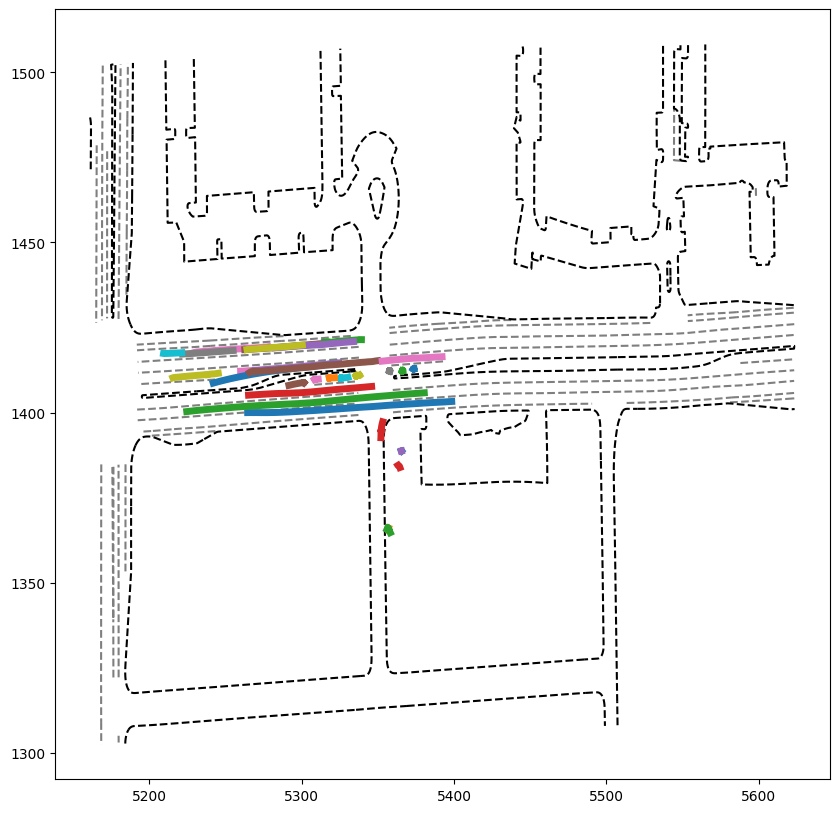

In [11]:
# Visualize scenario.
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

visualizations.add_map(ax, scenario)


def plot_track_trajectory(track: scenario_pb2.Track) -> None:
  valids = np.array([state.valid for state in track.states])
  if np.any(valids):
    x = np.array([state.center_x for state in track.states])
    y = np.array([state.center_y for state in track.states])
    ax.plot(x[valids], y[valids], linewidth=5)


for track in scenario.tracks:
  plot_track_trajectory(track)

plt.show()

# Rollout (Simulation using our model)

In [ ]:
from torch_geometric.data import HeteroData
from dataset.dataset import MultiDataset
from model.smart import SMART
from utils.config import load_config_act
from transforms.target_builder import WaymoTargetBuilder
import torch
from scipy.interpolate import CubicSpline

def smooth_upsample_knots_to_0p1(traj, shift=5, dt=0.1):
    """
    traj: (num_agents, T+1, 4) with knot values filled at indices 0, shift, 2*shift, ...
          columns: [x, y, z, yaw]
    Returns: same shape (num_agents, T+1, 4) fully filled with smooth 0.1s samples.
    """
    num_agents, Tp1, D = traj.shape
    assert D == 4
    T = Tp1 - 1

    knot_idx = np.arange(0, Tp1, shift)          # e.g. [0,5,10,...,80]
    t_k = knot_idx * dt
    t = np.arange(0, Tp1) * dt

    out = traj.copy()

    for i in range(num_agents):
        # --- x,y,z: C2-smooth spline (smooth velocity + acceleration) ---
        for dim in (0, 1, 2):
            yk = traj[i, knot_idx, dim]
            cs = CubicSpline(t_k, yk, bc_type="natural")
            out[i, :, dim] = cs(t)

        # --- yaw: spline sin/cos to avoid wrap discontinuity ---
        yaw_k = traj[i, knot_idx, 3]
        s_k = np.sin(yaw_k)
        c_k = np.cos(yaw_k)

        cs_s = CubicSpline(t_k, s_k, bc_type="natural")
        cs_c = CubicSpline(t_k, c_k, bc_type="natural")

        s = cs_s(t)
        c = cs_c(t)

        # normalize (keeps it on unit circle; helps avoid drift)
        norm = np.maximum(np.sqrt(s*s + c*c), 1e-8)
        s /= norm
        c /= norm

        out[i, :, 3] = np.arctan2(s, c)

    return out

def interp_angle_shortest(a0, a1, alpha):
        # a0,a1: (...,) in radians, alpha scalar in [0,1]
        c = (1 - alpha) * np.cos(a0) + alpha * np.cos(a1)
        s = (1 - alpha) * np.sin(a0) + alpha * np.sin(a1)
        return np.arctan2(s, c)
    
def dict_to_device(d,device):
        for key, item in d.items():
                if type(item) == torch.Tensor:
                        d[key] = item.to(device)
                elif type(item) == dict:
                        dict_to_device(item,device)
                else:
                        NotImplementedError

def simulate(model, scenario: scenario_pb2.Scenario, processed_data: HeteroData, print_verbose_comments: bool = False)->tf.Tensor:
        vprint = print if print_verbose_comments else lambda arg: None
        # To load the data, we create a simple tensorized version of the object tracks.
        logged_trajectories = trajectory_utils.ObjectTrajectories.from_scenario(scenario)

        # Using `ObjectTrajectories` we can select just the objects that we need to
        # simulate and remove the "future" part of the Scenario.
        vprint(
        'Original shape of tensors inside trajectories:'
        f' {logged_trajectories.valid.shape} (n_objects, n_steps)'
        )
        logged_trajectories = logged_trajectories.gather_objects_by_id(
        tf.convert_to_tensor(
                submission_specs.get_sim_agent_ids(scenario, challenge_type)
        )
        )
        logged_trajectories = logged_trajectories.slice_time(
        start_index=0, end_index=submission_config.current_time_index + 1
        )
        vprint(
        'Modified shape of tensors inside trajectories:'
        f' {logged_trajectories.valid.shape} (n_objects, n_steps)'
        )

        # We can verify that all of these objects are valid at the last step.
        vprint(
        'Are all agents valid:'
        f' {tf.reduce_all(logged_trajectories.valid[:, -1]).numpy()}'
        )
        #
        #Simulate using our trained sim agent model
        num_recurrent_steps_val = processed_data["agent"]['position'].shape[1] - model.num_historical_steps
        num_token_steps = num_recurrent_steps_val // model.encoder.agent_encoder.shift
        num_agents = len(processed_data["agent"]['id'])

        simulated_trajectories = np.zeros((submission_config.n_rollouts,num_agents,submission_config.n_simulation_steps+1,4))

        #Set the initial time step as the current state aka last logged trajectory (index 10)
        simulated_trajectories[:,:,0,0] = logged_trajectories.x.numpy()[:,-1]
        simulated_trajectories[:,:,0,1] = logged_trajectories.y.numpy()[:,-1]
        simulated_trajectories[:,:,0,2] = logged_trajectories.z.numpy()[:,-1]
        simulated_trajectories[:,:,0,3] = logged_trajectories.heading.numpy()[:,-1]

        vprint('Generating 'f'{submission_config.n_rollouts} trajectories for scenario {scenario.scenario_id}')
        dict_to_device(processed_data,model.device)
        data_init = processed_data
        z_average = processed_data['agent']['position'][:,:,-1].mean(dim=1)
        shift = model.encoder.agent_encoder.shift
        model.eval()
        torch.set_grad_enabled(False)
        
        with torch.inference_mode():
                for j in range(submission_config.n_rollouts):
                        data = model.match_token_map(data_init)
                        data = model.sample_pt_pred(data)
                        state = model.inference_one_step_init(data)
                        for t in range(num_token_steps):
                                out = model.inference_rollout_step(state, t)
                                pred_center = state["pos_a"] #(x,y) position only
                                hist_token_idx = state["hist_token_idx"]
                                heading = state['head_a']
                                pred_z = z_average #average z coordinate of each agent across agent history

                                #Copy the rollout states to trajectories
                                simulated_trajectories[j,:,(t+1)*shift,:2] = pred_center[:,hist_token_idx +t,:].cpu().numpy()
                                simulated_trajectories[j,:,(t+1)*shift, 2] = pred_z.cpu().numpy()
                                simulated_trajectories[j,:,(t+1)*shift, 3] = wrap_angle(heading[:,hist_token_idx + t].cpu().numpy())

                        # Since our motion token is discretized with dt=0.5s but the simulation must be in dt=0.1s, we do linear interpolation
                        for k in range(shift,submission_config.n_simulation_steps+1,shift):
                                ctr = 0
                                for m in range(k-shift,k):
                                        simulated_trajectories[j,:,m,:2] = simulated_trajectories[j,:,k-shift,:2] + (ctr/shift) * (simulated_trajectories[j,:,k,:2] - simulated_trajectories[j,:,k-shift,:2])
                                        simulated_trajectories[j,:,m, 2] = simulated_trajectories[j,:,k-shift,2] + (ctr/shift) * (simulated_trajectories[j,:,k,2] - simulated_trajectories[j,:,k-shift,2])
                                        # simulated_trajectories[j,:,m, 3] = wrap_angle(simulated_trajectories[j,:,k-shift,3] + (ctr/shift) * (simulated_trajectories[j,:,k,3] - simulated_trajectories[j,:,k-shift,3]))
                                        simulated_trajectories[j, :, m, 3] = interp_angle_shortest(
                                                                                simulated_trajectories[j, :, k-shift, 3],
                                                                                simulated_trajectories[j, :, k,       3],
                                                                                ctr / shift
                                                                                )

                                        ctr+=1
                                        
        simulated_trajectories_tf = tf.convert_to_tensor(simulated_trajectories[:,:,1:,:])
        assert simulated_trajectories_tf.shape == (submission_config.n_rollouts,num_agents,cfg.time_info.num_future_steps,4)
        return logged_trajectories, simulated_trajectories_tf

def get_processed_scenario(scenario, dataset):
        idx = dataset.query_index(scenario.scenario_id)
        try:
               return dataset.get(idx[0])
        except:
               print(f'Scenario ID: {scenario.scenario_id} could not be found')

torch.manual_seed(2026)
config_dir = '/home/hansung/end2end_ad/src/configs/validation/validation_rl.yaml'
cfg = load_config_act(config_dir)

#Load the model
if cfg.finetuning.pretrain_ckpt:
        print(f"Loading pretrained model from: {cfg.finetuning.pretrain_ckpt}")
        model = SMART.load_from_checkpoint(
                cfg.finetuning.pretrain_ckpt,
                model_config=cfg.Model,   # <-- must match SMART.__init__ signature
                strict=True,
                )
        model.to('cuda' if torch.cuda.is_available() else 'cpu')
else:
        NotImplementedError

#Initialize the dataset
if dataset_mode == 'val':
        processed_dataset = MultiDataset(None, 'val', processed_dir=cfg.Dataset.val_processed_dir, raw_dir=cfg.Dataset.val_raw_dir, processor='ntp', transform=WaymoTargetBuilder(cfg.time_info.num_historical_steps, cfg.time_info.num_future_steps, "val"), token_size=cfg.time_info.token_size,smart_token=cfg.Model.use_smart_tokens)
else:
        processed_dataset = MultiDataset(None, 'test', processed_dir=cfg.Dataset.test_processed_dir, raw_dir=cfg.Dataset.test_raw_dir, processor='ntp', transform=WaymoTargetBuilder(cfg.time_info.num_historical_steps, cfg.time_info.num_future_steps), token_size=cfg.time_info.token_size,smart_token=cfg.Model.use_smart_tokens)

# Process an example scenario
print(scenario.scenario_id)
processed_data = get_processed_scenario(scenario,processed_dataset) #get the correesponding processed data
logged_trajectories, simulated_states = simulate(model, scenario, processed_data, True)




# Batched Rollout (if you have enough VRAM in your GPU)
If you don't have enough VRAM and try to run this, it will result in OutOfMemoryError, which is fine. It just means that evaluation and submission generation will take longer.

In [ ]:
from torch_geometric.data import HeteroData, DataLoader, Batch
from dataset.dataset import MultiDataset
from model.smart import SMART
from utils.config import load_config_act
from transforms.target_builder import WaymoTargetBuilder
import torch
from scipy.interpolate import CubicSpline
from torch.utils.data.dataloader import default_collate

def smooth_upsample_knots_to_0p1(traj, shift=5, dt=0.1):
    """
    traj: (num_agents, T+1, 4) with knot values filled at indices 0, shift, 2*shift, ...
          columns: [x, y, z, yaw]
    Returns: same shape (num_agents, T+1, 4) fully filled with smooth 0.1s samples.
    """
    num_agents, Tp1, D = traj.shape
    assert D == 4
    T = Tp1 - 1

    knot_idx = np.arange(0, Tp1, shift)          # e.g. [0,5,10,...,80]
    t_k = knot_idx * dt
    t = np.arange(0, Tp1) * dt

    out = traj.copy()

    for i in range(num_agents):
        # --- x,y,z: C2-smooth spline (smooth velocity + acceleration) ---
        for dim in (0, 1, 2):
            yk = traj[i, knot_idx, dim]
            cs = CubicSpline(t_k, yk, bc_type="natural")
            out[i, :, dim] = cs(t)

        # --- yaw: spline sin/cos to avoid wrap discontinuity ---
        yaw_k = traj[i, knot_idx, 3]
        s_k = np.sin(yaw_k)
        c_k = np.cos(yaw_k)

        cs_s = CubicSpline(t_k, s_k, bc_type="natural")
        cs_c = CubicSpline(t_k, c_k, bc_type="natural")

        s = cs_s(t)
        c = cs_c(t)

        # normalize (keeps it on unit circle; helps avoid drift)
        norm = np.maximum(np.sqrt(s*s + c*c), 1e-8)
        s /= norm
        c /= norm

        out[i, :, 3] = np.arctan2(s, c)

    return out

def interp_angle_shortest(a0, a1, alpha):
        # a0,a1: (...,) in radians, alpha scalar in [0,1]
        c = (1 - alpha) * np.cos(a0) + alpha * np.cos(a1)
        s = (1 - alpha) * np.sin(a0) + alpha * np.sin(a1)
        return np.arctan2(s, c)
    
def dict_to_device(d,device):
        for key, item in d.items():
                if type(item) == torch.Tensor:
                        d[key] = item.to(device)
                elif type(item) == dict:
                        dict_to_device(item,device)
                else:
                        NotImplementedError

def batched_simulate(model, scenario, processed_data: HeteroData, print_verbose_comments: bool = False, batch_size: int = 1) -> tf.Tensor:
    """
    Simulate trajectories with optimized memory usage and vectorized interpolation.
    """
    vprint = print if print_verbose_comments else lambda arg: None

    # --- 1. Load Ground Truth Object Tracks ---
    logged_trajectories = trajectory_utils.ObjectTrajectories.from_scenario(scenario)
    vprint(f'Original shape: {logged_trajectories.valid.shape} (n_objects, n_steps)')

    logged_trajectories = logged_trajectories.gather_objects_by_id(
        tf.convert_to_tensor(submission_specs.get_sim_agent_ids(scenario, challenge_type))
    )
    logged_trajectories = logged_trajectories.slice_time(
        start_index=0, end_index=submission_config.current_time_index + 1
    )
    vprint(f'Modified shape: {logged_trajectories.valid.shape}')

    data_list = [processed_data] * submission_config.n_rollouts
    
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=False)

    num_recurrent_steps_val = processed_data["agent"]['position'].shape[1] - model.num_historical_steps
    shift = model.encoder.agent_encoder.shift

    # Calculate how many token steps we need to simulate
    num_token_steps = submission_config.n_simulation_steps // shift
    
    num_agents = len(processed_data["agent"]['id'])
    
    sim_traj = np.zeros((submission_config.n_rollouts, num_agents, submission_config.n_simulation_steps + 1, 4))

    # Initialize t=0 with the last known state
    sim_traj[:, :, 0, 0] = logged_trajectories.x.numpy()[:, -1]
    sim_traj[:, :, 0, 1] = logged_trajectories.y.numpy()[:, -1]
    sim_traj[:, :, 0, 2] = logged_trajectories.z.numpy()[:, -1]
    sim_traj[:, :, 0, 3] = logged_trajectories.heading.numpy()[:, -1]

    vprint(f'Generating {submission_config.n_rollouts} trajectories...')
    
    # Pre-calculate constants
    z_average = processed_data['agent']['position'][:, :, -1].mean(dim=1).cpu().numpy() # (num_agents,)

    model.eval()
    torch.set_grad_enabled(False)
    
    start_idx = 0
    
    with torch.inference_mode():
        for batch in loader:
            current_bs = batch.num_graphs
            
            # Move batch to GPU
            data = model.match_token_map(batch)
            data = model.sample_pt_pred(data)
            data = data.to(model.device)

            # Initialize autoregressive state
            state = model.inference_one_step_init(data)
            
            # Autoregressive Rollout
            for t in range(num_token_steps):
                model.inference_rollout_step(state, t)
                
                # Extract predictions
                # shape: (current_bs * num_agents, 1, 2) -> reshape to (current_bs, num_agents, 2)
                hist_token_idx = state["hist_token_idx"]
                
                # Position (x, y)
                pred_center = state["pos_a"][:, hist_token_idx + t, :].cpu().numpy()
                pred_center = pred_center.reshape(current_bs, num_agents, 2)
                
                # Heading
                heading = state['head_a'][:, hist_token_idx + t].cpu().numpy()
                heading = wrap_angle(heading).reshape(current_bs, num_agents)

                # Store Knot Points (every 'shift' steps)
                # target_idx matches the future time step: (t+1)*shift
                target_t_idx = (t + 1) * shift
                
                if target_t_idx <= submission_config.n_simulation_steps:
                    sim_traj[start_idx:start_idx+current_bs, :, target_t_idx, :2] = pred_center
                    sim_traj[start_idx:start_idx+current_bs, :, target_t_idx, 2]  = z_average
                    sim_traj[start_idx:start_idx+current_bs, :, target_t_idx, 3]  = heading
            
            for step in range(1, num_token_steps + 1):
                t_end = step * shift
                t_start = (step - 1) * shift
                
                if t_end > submission_config.n_simulation_steps:
                    break

                # Get start and end knots
                p_start = sim_traj[start_idx:start_idx+current_bs, :, t_start, :]
                p_end   = sim_traj[start_idx:start_idx+current_bs, :, t_end, :]

                alphas = np.linspace(0, 1, shift + 1)[1:-1] # excludes 0 and 1
                
                # Linear Interp for X, Y, Z
                interp_xyz = (1 - alphas[:, None, None, None]) * p_start[:, :, :3] + \
                             (alphas[:, None, None, None]) * p_end[:, :, :3]
                interp_xyz = interp_xyz.transpose(1, 2, 0, 3)

                # Slerp/Shortest Angle Interp for Yaw
                a0 = p_start[:, :, 3]
                a1 = p_end[:, :, 3]
                
                # Vectorized angle interpolation
                alphas_expanded = alphas[:, None, None] # (steps, 1, 1)
                c = (1 - alphas_expanded) * np.cos(a0) + alphas_expanded * np.cos(a1)
                s = (1 - alphas_expanded) * np.sin(a0) + alphas_expanded * np.sin(a1)
                interp_yaw = np.arctan2(s, c) # (shift-1, bs, agents)
                interp_yaw = interp_yaw.transpose(1, 2, 0) # (bs, agents, shift-1)

                # Assign back to main array
                sim_traj[start_idx:start_idx+current_bs, :, t_start+1 : t_end, :3] = interp_xyz
                sim_traj[start_idx:start_idx+current_bs, :, t_start+1 : t_end, 3]  = interp_yaw

            del data, state
            torch.cuda.empty_cache()
            
            start_idx += current_bs

    # Convert to TF tensor as required
    simulated_trajectories_tf = tf.convert_to_tensor(sim_traj[:, :, 1:, :], dtype=tf.float32)
    return logged_trajectories, simulated_trajectories_tf

def get_processed_scenario(scenario, dataset):
        idx = dataset.query_index(scenario.scenario_id)
        try:
               return dataset.get(idx[0])
        except:
               print(f'Scenario ID: {scenario.scenario_id} could not be found')

torch.manual_seed(2026)
config_dir = '/home/hansung/end2end_ad/src/configs/validation/validation_rl.yaml'
cfg = load_config_act(config_dir)

#Load the model
if cfg.finetuning.pretrain_ckpt:
        print(f"Loading pretrained model from: {cfg.finetuning.pretrain_ckpt}")
        model = SMART.load_from_checkpoint(
                cfg.finetuning.pretrain_ckpt,
                model_config=cfg.Model,   # <-- must match SMART.__init__ signature
                strict=True,
                )
        model.to('cuda' if torch.cuda.is_available() else 'cpu')
else:
        NotImplementedError

#Initialize the dataset
if dataset_mode == 'val':
        processed_dataset = MultiDataset(None, 'val', processed_dir=cfg.Dataset.val_processed_dir, raw_dir=cfg.Dataset.val_raw_dir, processor='ntp', transform=WaymoTargetBuilder(cfg.time_info.num_historical_steps, cfg.time_info.num_future_steps, "val"), token_size=cfg.time_info.token_size,smart_token=cfg.Model.use_smart_tokens)
else:
        processed_dataset = MultiDataset(None, 'test', processed_dir=cfg.Dataset.test_processed_dir, raw_dir=cfg.Dataset.test_raw_dir, processor='ntp', transform=WaymoTargetBuilder(cfg.time_info.num_historical_steps, cfg.time_info.num_future_steps), token_size=cfg.time_info.token_size,smart_token=cfg.Model.use_smart_tokens)

# Process an example scenario
print(scenario.scenario_id)
# torch.multiprocessing.set_start_method('spawn')
processed_data = get_processed_scenario(scenario,processed_dataset) #get the correesponding processed data
logged_trajectories, simulated_states = batched_simulate(model, scenario, HeteroData(processed_data), True,batch_size=16)




2025-12-18 07:56:13,578-DEBUG-dataset.py-Line:38-Message:Starting loading dataset
2025-12-18 07:56:13,599-DEBUG-dataset.py-Line:61-Message:The number of val dataset is 44097


Loading pretrained model from: checkpoints/finetuning/last_mapkeys_fixed.ckpt
Initialized TokenProcessor with Token Size 2048, use_smart_token: True
75ae707721eb23b4


/tmp/ipykernel_2202546/2038801810.py:92: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(data_list, batch_size=batch_size, shuffle=False)


Original shape: (23, 91) (n_objects, n_steps)
Modified shape: (12, 11)
Generating 32 trajectories...


### Visualize the simulated trajectories

In [17]:
SAMPLE_INDEX = 0
# We need to extract box sizes (length and width) for all the simulated objects,
# from the 11th step (when one-indexed) of the original scenario.
# Also broadcast in time to be compatible with the other tensors,
# shape (num_objects, num_steps).
n_objects = logged_trajectories.valid.shape[0]
lengths = tf.broadcast_to(
    logged_trajectories.length[:, 10, tf.newaxis],
    (n_objects, submission_config.n_simulation_steps),
)
widths = tf.broadcast_to(
    logged_trajectories.width[:, 10, tf.newaxis],
    (n_objects, submission_config.n_simulation_steps),
)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
anim = visualizations.get_animated_states(
    fig,
    ax,
    scenario,
    simulated_states[SAMPLE_INDEX, :, :, 0],
    simulated_states[SAMPLE_INDEX, :, :, 1],
    simulated_states[SAMPLE_INDEX, :, :, 3],
    lengths,
    widths,
    color_idx=tf.zeros((70, 80), dtype=tf.int32),
)
HTML(anim.to_jshtml())

In [14]:
from IPython.display import HTML
from matplotlib.animation import FFMpegWriter

# Select which how the 32 simulations we want visualize.
os.makedirs(f'../demo/{scenario.scenario_id}', exist_ok=True)
for i in range(submission_config.n_rollouts):
    SAMPLE_INDEX = i
    # We need to extract box sizes (length and width) for all the simulated objects,
    # from the 11th step (when one-indexed) of the original scenario.
    # Also broadcast in time to be compatible with the other tensors,
    # shape (num_objects, num_steps).
    n_objects = logged_trajectories.valid.shape[0]
    lengths = tf.broadcast_to(
        logged_trajectories.length[:, 10, tf.newaxis],
        (n_objects, submission_config.n_simulation_steps),
    )
    widths = tf.broadcast_to(
        logged_trajectories.width[:, 10, tf.newaxis],
        (n_objects, submission_config.n_simulation_steps),
    )

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    anim = visualizations.get_animated_states(
        fig,
        ax,
        scenario,
        simulated_states[SAMPLE_INDEX, :, :, 0],
        simulated_states[SAMPLE_INDEX, :, :, 1],
        simulated_states[SAMPLE_INDEX, :, :, 3],
        lengths,
        widths,
        color_idx=tf.zeros((70, 80), dtype=tf.int32),
    )

    cx = logged_trajectories.x[processed_data['agent']['av_index'],0].numpy()
    cy = logged_trajectories.y[processed_data['agent']['av_index'],0].numpy()
    dist = 130
    ax.set_xlim(cx - dist,cx+dist)
    ax.set_ylim(cy - dist, cy + dist)
    # Make x/y have the same scale
    ax.set_aspect("equal", adjustable="box")   # or adjustable="datalim"

    # UNCOMMENT IF YOU WANT TO VISUALIZE A SAMPLE IN THE NOTEBOOK and don't iterate (for loop)
    # HTML(anim.to_jshtml())

    writer = FFMpegWriter(fps=10, bitrate=2000)
    anim.save(f"../demo/{scenario.scenario_id}/validation_{scenario.scenario_id}_{SAMPLE_INDEX}.mp4", writer=writer)


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1000', '-pix_fmt', 'rgba', '-framerate', '10', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '2000k', '-y', '../demo/75ae707721eb23b4/validation_75ae707721eb23b4_3.mp4']' returned non-zero exit status 255.

In [15]:
def joint_scene_from_states(
    states: tf.Tensor, object_ids: tf.Tensor
) -> sim_agents_submission_pb2.JointScene:
  # States shape: (num_objects, num_steps, 4).
  # Objects IDs shape: (num_objects,).
  states = states.numpy()
  simulated_trajectories = []
  for i_object in range(len(object_ids)):
    simulated_trajectories.append(
        sim_agents_submission_pb2.SimulatedTrajectory(
            center_x=states[i_object, :, 0],
            center_y=states[i_object, :, 1],
            center_z=states[i_object, :, 2],
            heading=states[i_object, :, 3],
            object_id=object_ids[i_object],
        )
    )
  return sim_agents_submission_pb2.JointScene(
      simulated_trajectories=simulated_trajectories
  )


# Package the first simulation into a `JointScene`
joint_scene = joint_scene_from_states(
    simulated_states[0, :, :, :], logged_trajectories.object_id
)
# Validate the joint scene. Should raise an exception if it's invalid.
submission_specs.validate_joint_scene(joint_scene, scenario, challenge_type)


# Now we can replicate this strategy to export all the parallel simulations.
def scenario_rollouts_from_states(
    scenario: scenario_pb2.Scenario, states: tf.Tensor, object_ids: tf.Tensor
) -> sim_agents_submission_pb2.ScenarioRollouts:
  # States shape: (num_rollouts, num_objects, num_steps, 4).
  # Objects IDs shape: (num_objects,).
  joint_scenes = []
  for i_rollout in range(states.shape[0]):
    joint_scenes.append(joint_scene_from_states(states[i_rollout], object_ids))
  return sim_agents_submission_pb2.ScenarioRollouts(
      # Note: remember to include the Scenario ID in the proto message.
      joint_scenes=joint_scenes,
      scenario_id=scenario.scenario_id,
  )


scenario_rollouts = scenario_rollouts_from_states(
    scenario, simulated_states, logged_trajectories.object_id
)
# As before, we can validate the message we just generate.
submission_specs.validate_scenario_rollouts(scenario_rollouts, scenario)

## Evaluation

Once we have created the submission for a single Scenario, we can evaluate the
simulations we have performed.

The evaluation of sim agents is trying to capture distributional realism, i.e.
how well our simulations capture the distribution of human behaviour from the
real world. A key difference to the existing Behaviour Prediction task, is that
we are focusing our comparison on quantities (**features**) that try to capture
the behaviour of humans.

More specifically, for this challenge we will look at the following features: -
Kinematic features: speed / accelerations of objects, both linear and angular. -
Interactive features: features capturing relationships between objects, like
collisions, distances to other objects and time to collision (TTC). - Map-based
features: features capturing how objects move with respect to the road itself,
e.g. going offroad for a car.

While we require all those objects to be simulated, we are going to evaluate
only a subset of them, namely the `tracks_to_predict` inside the Scenario. This
criteria was put in place to ensure less noisy measures, as these objects will
have consistently long observations from the real world, which we need to
properly evaluate our agents.

Note that, while all the other sim agents are not *directly* evaluated, they are
still part of the simulation. This means that all the interactive features will
be computed considering those sim agents, and the *evaluated* sim agents needs
to be reactive to these objects.

Now let's compute the features to understand better the evaluation in practice.
Everything is included inside `metric_features.py`.

In [ ]:
if dataset_mode == 'val':
    # Compute the features for a single JointScene.
    single_scene_features = metric_features.compute_metric_features(
        scenario, joint_scene
    )

In [ ]:
if dataset_mode == 'val':  
  # These features will be computed only for the `tracks_to_predict` objects.
  print(
      'Evaluated objects:'
      f' {submission_specs.get_evaluation_sim_agent_ids(scenario, challenge_type)}'
  )
  # This will also match single_scene_features.object_ids
  print(f'Evaluated objects in features: {single_scene_features.object_id}')

  # Features contain a validity flag, which for simulated rollouts must be always
  # True, because we are requiring the sim agents to be always valid when replaced.
  print(f'Are all agents valid: {tf.reduce_all(single_scene_features.valid)}')

  # ============ FEATURES ============
  # Average displacement feature. This corresponds to ADE in the BP challenges,
  # here is used just as a comparison (it's not actually included in the final score).
  # Shape: (1, n_objects).
  print(
      f'ADE: {tf.reduce_mean(single_scene_features.average_displacement_error)}'
  )

  # Kinematic features.
  print('\n============ KINEMATIC FEATURES ============')
  fig, axes = plt.subplots(1, 4, figsize=(16, 4))
  for i_object in range(len(single_scene_features.object_id)):
    _object_id = single_scene_features.object_id[i_object].numpy()
    axes[0].plot(
        single_scene_features.linear_speed[0, i_object, :], label=str(_object_id)
    )
    axes[1].plot(
        single_scene_features.linear_acceleration[0, i_object, :],
        label=str(_object_id),
    )
    axes[2].plot(
        single_scene_features.angular_speed[0, i_object, :], label=str(_object_id)
    )
    axes[3].plot(
        single_scene_features.angular_acceleration[0, i_object, :],
        label=str(_object_id),
    )


  TITLES = [
      'linear_speed',
      'linear_acceleration',
      'angular_speed',
      'angular_acceleration',
  ]
  for ax, title in zip(axes, TITLES):
    ax.legend()
    ax.set_title(title)
  plt.show()

  # Interactive features.
  print('\n============ INTERACTIVE FEATURES ============')
  print(f'Colliding objects: {single_scene_features.collision_per_step[0]}')
  fig, axes = plt.subplots(1, 2, figsize=(8, 4))
  for i_object in range(len(single_scene_features.object_id)):
    _object_id = single_scene_features.object_id[i_object].numpy()
    axes[0].plot(
        single_scene_features.distance_to_nearest_object[0, i_object, :],
        label=str(_object_id),
    )
    axes[1].plot(
        single_scene_features.time_to_collision[0, i_object, :],
        label=str(_object_id),
    )

  TITLES = ['distance to nearest object', 'time to collision']
  for ax, title in zip(axes, TITLES):
    ax.legend()
    ax.set_title(title)
  plt.show()

  # Map-based features.
  print('\n============ MAP-BASED FEATURES ============')
  print(f'Offroad objects: {single_scene_features.offroad_per_step[0]}')
  fig, axes = plt.subplots(1, 1, figsize=(4, 4))
  for i_object in range(len(single_scene_features.object_id)):
    _object_id = single_scene_features.object_id[i_object].numpy()
    axes.plot(
        single_scene_features.distance_to_road_edge[0, i_object, :],
        label=str(_object_id),
    )
  axes.legend()
  axes.set_title('distance to road edge')

  plt.show()

These features are computed for each of the submitted `JointScenes`. So, for a
given `ScenarioRollouts` we actually get a distribution of these features over
the parallel rollouts.

The final metric we will be evaluating is a measure of the likelihood of what
happened in real life, compared to the distribution of what *we predicted might
have happened* (in simulation). For more details see the challenge
documentation.

The final metrics can be called directly from `metrics.py`, as shown below.

Some of the details of how these metrics are computed and aggregated can be
found in `SimAgentMetricsConfig`. The following code demonstrates how to load
the config used for the challenge and how to score your own submission.

In [ ]:
if dataset_mode == 'val':
    # Load the test configuration.
    config = metrics.load_metrics_config(challenge_type)

    scenario_metrics = metrics.compute_scenario_metrics_for_bundle(
        config, scenario, scenario_rollouts
    )
    print(scenario_metrics)

As you can see, there is a score in the range [0,1] for each of the features
listed above. The new field to highlight is `metametric`: this is a linear
combination of the per-feature scores, and it's the final metric used to score
and rank submissions.